# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></div><div class="lev1 toc-item"><a href="#Naive-Bayes" data-toc-modified-id="Naive-Bayes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Naive Bayes</a></div><div class="lev1 toc-item"><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Logistic regression</a></div>

# Setup

First we load the usual libraries, along with the spam dataset from the Elements of Statistical Learning package, `e1071` for an implementation of naive Bayes, and ROCR for evaluation metrics.

In [2]:
library(tidyverse)
library(scales)
library(ElemStatLearn)
library(e1071)
library(ROCR)

theme_set(theme_bw())

options(repr.plot.width=4, repr.plot.height=3)

Next we use the `spam` dataset and split the data in to a train and test set (ignoring validation for the time being).
    
The outcome (`email` or `spam`) is in last column (#58).

In [3]:
set.seed(42)
ndx <- sample(nrow(spam), floor(nrow(spam) * 0.9))
train <- spam[ndx,]
test <- spam[-ndx,]

xTrain <- train[,-58]
yTrain <- train$spam
xTest <- test[,-58]
yTest <- test$spam

# Naive Bayes

Now we'll fit a naive Bayes model without any smoothing.

The model has tables for the prior class probabilities (`apriori`) as well as for each feature (`tables`), and some extra info.

In [4]:
model <- naiveBayes(xTrain, yTrain)
summary(model)

          Length Class  Mode     
apriori    2     table  numeric  
tables    57     -none- list     
levels     2     -none- character
isnumeric 57     -none- logical  
call       3     -none- call     

Now we'll make predictions, which will be default return the most probable class label for each test example.

In [5]:
df <- data.frame(actual = yTest,
                 pred = predict(model, xTest))
head(df)

actual,pred
spam,spam
spam,spam
spam,spam
spam,spam
spam,spam
spam,spam


The confusion matrix gives a summary of the classifiers performance, with the actual label determining the row, and the predicted label giving the column.

In [6]:
table(df)

       pred
actual  email spam
  email   139  116
  spam     12  194

We can summarize this in a dizzying number of ways, each of which has multiple names.

A few useful and popular metrics are listed below.

In [7]:
# accuracy: fraction of correct classifications
df %>%
  summarize(acc = mean(pred == actual))

# precision: fraction of positive predictions that are actually true
df %>%
  filter(pred == 'spam') %>%
  summarize(prec = mean(actual == 'spam'))

# recall: fraction of true examples that we predicted to be positive
# aka true positive rate, sensitivity
df %>%
  filter(actual == 'spam') %>%
  summarize(recall = mean(pred == 'spam'))

# false positive rate: fraction of false examples that we predicted to be positive
df %>%
  filter(actual == 'email') %>%
  summarize(fpr = mean(pred == 'spam'))

acc
0.7223427


prec
0.6258065


recall
0.9417476


fpr
0.454902


Next week can look at the raw probabilities predicted by naive Bayes by calling `predict` with `type = raw`, and examine a histogram of all predictions.

Note that this is highly bimodal because naive Bayes is overconfident, a result of the independence assumption.

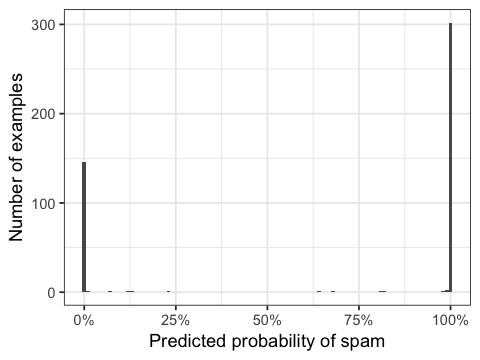

In [8]:
# plot histogram of predicted probabilities
# note overconfident predictions
probs <- data.frame(predict(model, xTest, type="raw"))

ggplot(probs, aes(x = spam)) +
  geom_histogram(binwidth = 0.01) +
  scale_x_continuous(label = percent) +
  xlab('Predicted probability of spam') +
  ylab('Number of examples')

We can also check calibration by looking at how often predicted probabilities match actual frequencies.

This is most easily done by binning examples by their predicted probability of being spam and then counting how often those examples actually turn out to be spam.

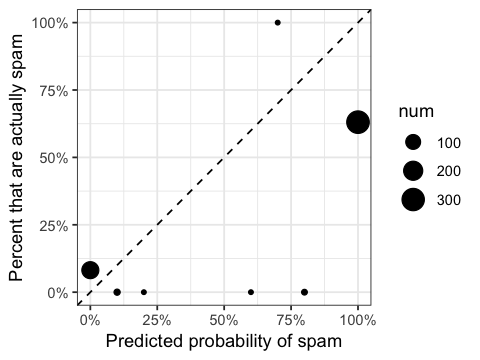

In [9]:
data.frame(predicted=probs[, "spam"], actual=yTest) %>%
  group_by(predicted=round(predicted*10)/10) %>%
  summarize(num=n(), actual=mean(actual == "spam")) %>%
  ggplot(data=., aes(x=predicted, y=actual, size=num)) +
  geom_point() +
  geom_abline(linetype=2) +
  scale_x_continuous(labels=percent, lim=c(0,1)) +
  scale_y_continuous(labels=percent, lim=c(0,1)) +
  xlab('Predicted probability of spam') +
  ylab('Percent that are actually spam')

We can use the `ROCR` package to make a plot of the receiver operator characteristic (ROC) curve and compute the area under the curve (AUC).

The ROC curve plots the true positive rate (also known as recall, sensitivity, or the probability of detecting a true example) against the false positive rate (also known as 1 - specificity, or the probability of a false alarm) as we change the threshold on the probability for predicting spam. In this case that's the fraction of all incoming spam detected vs. the fraction of legitimate emails that get labeled as spam.

An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.8539882


Slot "alpha.values":
list()


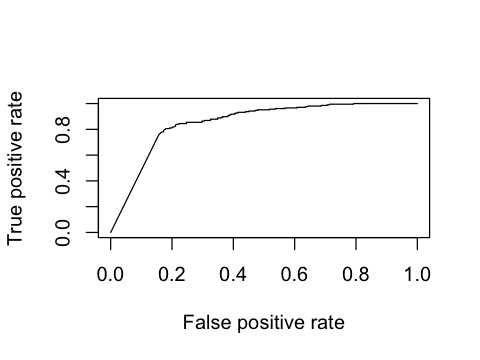

In [10]:
# create a ROCR object
pred <- prediction(probs[, "spam"], yTest)

# plot ROC curve
perf_nb <- performance(pred, measure='tpr', x.measure='fpr')
plot(perf_nb)
performance(pred, 'auc')

Note that the area under the curve (AUC) is equivalent to the probability of scoring a randomly sampled positive example above a randomly sampled negative one.

We can approximate this directly by repeated sampling of pairs of examples and checking for the correct ranking.

In [11]:
# sample pos/neg pairs
predicted <- probs[, "spam"]
actual <- yTest == "spam"
ndx_pos <- sample(which(actual == 1), size=100, replace=T)
ndx_neg <- sample(which(actual == 0), size=100, replace=T)
mean(predicted[ndx_pos] > predicted[ndx_neg])

[1] 0.77

# Logistic regression

Next we'll fit a logistic regression model for the same data.

Notice that the model is represented here by one weight for each feature. This is equivalent to the form of the predictor for naive Bayes, but all of the weights are learned together instead of being learned independently.

In [12]:
model <- glm(spam ~ ., data=spam[ndx, ], family="binomial")
model
#summary(model)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Call:  glm(formula = spam ~ ., family = "binomial", data = spam[ndx, 
    ])

Coefficients:
(Intercept)          A.1          A.2          A.3          A.4          A.5  
 -1.641e+00   -3.008e-01   -1.854e-01    1.518e-01    2.867e+00    5.747e-01  
        A.6          A.7          A.8          A.9         A.10         A.11  
  8.963e-01    2.172e+00    5.103e-01    1.093e+00    2.304e-01   -2.654e-01  
       A.12         A.13         A.14         A.15         A.16         A.17  
 -1.801e-01    2.335e-02    1.361e-01    1.034e+00    1.089e+00    1.081e+00  
       A.18         A.19         A.20         A.21         A.22         A.23  
  1.027e-01    5.755e-02    8.663e-01    2.544e-01    2.620e-01    2.128e+00  
       A.24         A.25         A.26         A.27         A.28         A.29  
  7.238e-01   -1.863e+00   -8.376e-01   -1.156e+01    3.950e-01   -3.891e+00  
       A.30         A.31         A.32         A.33         A.34         A.35  
 -4.095e-01   -1.832e-01    2.639e+00 

Now we'll make predictions, which will be default return the log-odds of the example being spam.

In [13]:
df <- data.frame(actual = yTest,
                 log_odds = predict(model, xTest)) %>%
  mutate(pred = ifelse(log_odds > 0, 'spam', 'email'))
head(df)

actual,log_odds,pred
spam,12.6683570,spam
spam,1.2433717,spam
spam,1.8819751,spam
spam,0.3257722,spam
spam,-1.4373374,email
spam,0.4659602,spam


Now we'll look at the confusion matrix again, seeing better performance as indicated by the smaller off-diagonal entires.

In [14]:
table(actual = df$actual, predicted = df$pred)

       predicted
actual  email spam
  email   242   13
  spam     28  178

Summarizing this in various ways also reflects the improvement.

In [17]:
# accuracy: fraction of correct classifications
df %>%
    summarize(acc = mean(pred == actual))

# precision: fraction of positive predictions that are actually true
df %>%
  filter(pred == 'spam') %>%
  summarize(prec = mean(actual == 'spam'))

# recall: fraction of true examples that we predicted to be positive
# aka true positive rate, sensitivity
df %>%
  filter(actual == 'spam') %>%
  summarize(recall = mean(pred == 'spam'))

# false positive rate: fraction of false examples that we predicted to be positive
df %>%
  filter(actual == 'email') %>%
  summarize(fpr = mean(pred == 'spam'))

acc
0.9110629


prec
0.9319372


recall
0.8640777


fpr
0.05098039


Plotting the distribution of predicted probabilities shows that the overconfidence problem has been addressed.

Notice that you call `predict` with `type = response` to get probabilities instead of log-odds.

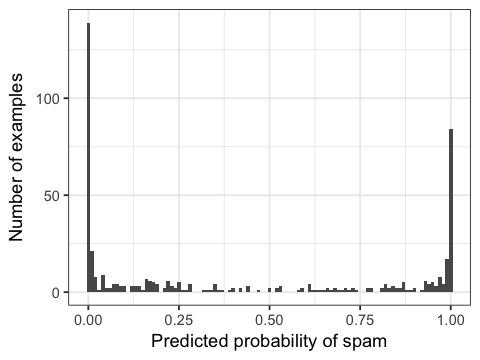

In [18]:
# plot histogram of predicted probabilities
plot_data <- spam[-ndx, ]
plot_data$probs <- predict(model, spam[-ndx, ], type="response")
ggplot(plot_data, aes(x = probs)) +
  geom_histogram(binwidth = 0.01) +
  xlab('Predicted probability of spam') +
  ylab('Number of examples')

And the calibration plot looks more sensible as well.

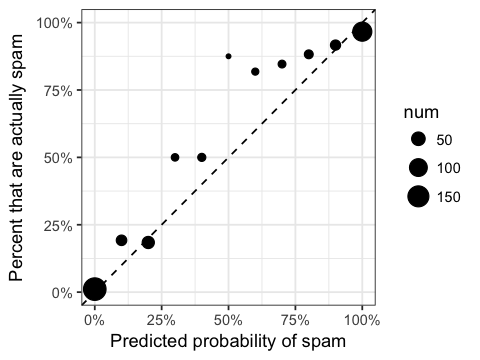

In [19]:
# plot calibration
data.frame(predicted=plot_data$probs, actual=yTest) %>%
  group_by(predicted=round(predicted*10)/10) %>%
  summarize(num=n(), actual=mean(actual == "spam")) %>%
  ggplot(data=., aes(x=predicted, y=actual, size=num)) +
  geom_point() +
  geom_abline(linetype=2) +
  scale_x_continuous(labels=percent, lim=c(0,1)) +
  scale_y_continuous(labels=percent, lim=c(0,1)) +
  xlab('Predicted probability of spam') +
  ylab('Percent that are actually spam')

Just as with naive Bayes, we can plot the ROC curve.

An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.9673139


Slot "alpha.values":
list()


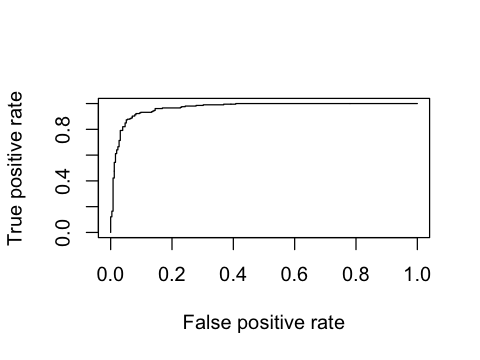

In [20]:
pred <- prediction(plot_data$probs, yTest)
perf_lr <- performance(pred, measure='tpr', x.measure='fpr')
plot(perf_lr)
performance(pred, 'auc')

And a sampling approach to approximate the AUC shows the same.

In [21]:
predicted <- plot_data$probs
actual <- yTest == "spam"
ndx_pos <- sample(which(actual == 1), size=100, replace=T)
ndx_neg <- sample(which(actual == 0), size=100, replace=T)
mean(predicted[ndx_pos] > predicted[ndx_neg])

[1] 0.98

Finally, we can combine both ROC curves on one clean plot.

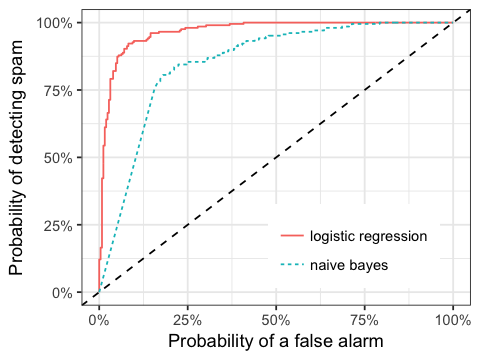

In [22]:
roc_nb <- data.frame(fpr=unlist(perf_nb@x.values), tpr=unlist(perf_nb@y.values))
roc_nb$method <- "naive bayes"
roc_lr <- data.frame(fpr=unlist(perf_lr@x.values), tpr=unlist(perf_lr@y.values))
roc_lr$method <- "logistic regression"
rbind(roc_nb, roc_lr) %>%
  ggplot(data=., aes(x=fpr, y=tpr, linetype=method, color=method)) + 
  geom_line() +
  geom_abline(linetype=2) +
  scale_x_continuous(labels=percent, lim=c(0,1)) +
  scale_y_continuous(labels=percent, lim=c(0,1)) +
  xlab('Probability of a false alarm') +
  ylab('Probability of detecting spam') +
  theme(legend.position=c(0.7,0.2), legend.title=element_blank())